# Adaptive PDE discretizations on Cartesian grids
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Forward and reverse differentiation

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Forward differentiation](#1.-Forward-differentiation)
    * [1.1 Isotropic model](#1.1-Isotropic-model)
    * [1.2 Anisotropic model](#1.2-Anisotropic-model)
    * [1.3 Curvature penalized model](#1.3-Curvature-penalized-model)
  * [2. Reverse differentiation](#2.-Reverse-differentiation)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('EikonalAD_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
Eikonal.dictIn.default_mode = 'gpu'

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)

## 1. Forward differentiation

### 1.1 Isotropic model

In [6]:
n=50
delta = ad.Dense.identity(constant=cp.zeros(2))
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.],[0.8,0.7],[0.,0.2]],
    'seedValues':ad.array([0.*delta[0], 0.2*(1.+delta[1]), 0.*delta[0]]),
    'exportValues':1,
    'traits':{
        'shape_i':(8,8),'niter_i':16,
    }
    
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X=hfmIn.Grid()

In [7]:
costValue = (1.+(X[1]<-0.3)).astype(hfmIn.float_t) # (float32 + bool) -> float64 -> float32
costVariation = 1.+delta[0]*(X[0]>0.) + delta[1]*(X[0]<=0) # Relative variation
hfmIn['cost'] = costValue*costVariation

In [8]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.007972955703735352 seconds, and 8 iterations.
Post-Processing


The first cost perturbation influences only the right part of the domain.

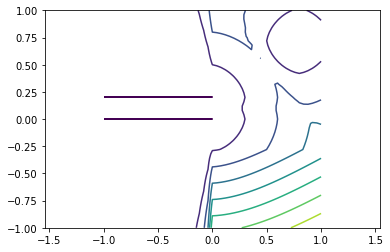

In [9]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].gradient(0));

The second perturbation influences the left part of the domain, as well as the rightmost seed value.

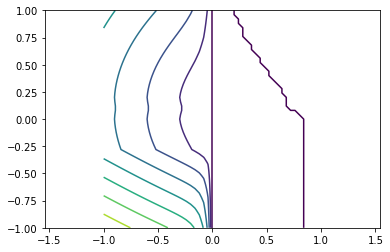

In [10]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].gradient(1));

By construction, the sum of these specific perturbations equals the value function.

In [11]:
assert norm_infinity(hfmOut['values'].value - hfmOut['values'].gradient().sum(axis=0)) < 1e-6

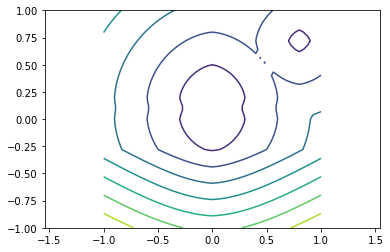

In [12]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].gradient().sum(axis=0));

We also test consistency with the CPU code.

In [13]:
hfmIn['mode'] = 'cpu_transfer'

In [14]:
hfmOut_cpu = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.001 s.


In [15]:
assert norm_infinity(hfmOut_cpu['values'].gradient() - hfmOut['values'].gradient().get()) < 1e-5

### 1.2 Anisotropic model

In [16]:
hfmIn = Eikonal.dictIn({
    'model':'Riemann2',
    'exportValues':True,
    'seed':(0,0),
})


### 1.3 Curvature penalized model

In [17]:
hfmIn = Eikonal.dictIn({
    'model':'Dubins2',
    'exportValues':True,
    'seed':[0,0,0],
    'xi':1.,
#    'precompute_scheme':False,
    'solver':'AGSI',
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=101)
hfmIn.nTheta = 96
X = hfmIn.Grid()

In [18]:
costValue = (1.+(X[1]<-0.3)).astype(hfmIn.float_t) # (float32 + bool) -> float64 -> float32
costVariation = 1.+delta[0]*(X[0]>0.) + delta[1]*(X[0]<=0) # Relative variation
hfmIn['cost'] = costValue*costVariation

In [19]:
hfmIn['mode'] = 'gpu' #'cpu_transfer'

In [20]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.1081855297088623 seconds, and 188 iterations.
Post-Processing


In [21]:
val = hfmOut['values']
diff = np.abs(np.where(np.isfinite(val), val.value - val.gradient().sum(axis=0), 0))

In [25]:
assert np.sum(diff>1e-4) / diff.size < 3e-3
assert np.max(diff/(1+val.value)) < 2e-2

## 2. Reverse differentiation

In [26]:
n=50
delta = ad.Dense.identity(constant=cp.zeros(2))
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.],[0.,0.5]],
#    'seeds':cp.array([[0.,0.],[0.8,0.7],[0.,0.2]]),
#    'seedValues':ad.array([0.*delta[0],0.2*(1.+delta[0]),0.*delta[0]]),
    'exportValues':1,
    'traits':{
        'shape_i':(8,8),'niter_i':16,
    },
    'cost':1.,
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X=hfmIn.Grid()

In [27]:
sensShape= (*hfmIn.shape,1)
sens = cp.zeros(sensShape)
sens[-1,-1] = 1.
hfmIn['sensitivity'] = sens

In [28]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.003987550735473633 seconds, and 11 iterations.
Post-Processing


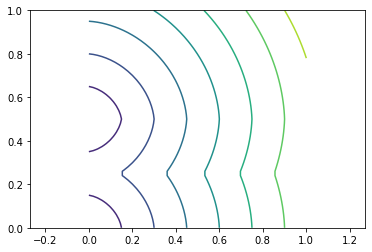

In [29]:
plt.axis('equal')
plt.contour(*X,hfmOut['values']);

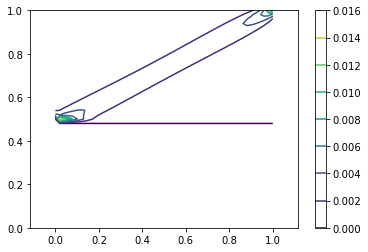

In [30]:
plt.axis('equal')
#cSens = hfmOut['costSensitivity'][0]; cSens[0,0]=0
plt.contour(*X,hfmOut['costSensitivity'][...,0]); plt.colorbar();

The tested point is only sensitive to the second seed value.

In [31]:
hfmOut['seedValueSensitivity']

array([[    0],
       [    1]], dtype=float32)

In [32]:
assert norm_infinity(hfmOut['seedValueSensitivity'] - cp.array([[0],[1]]))<1e-6